In [1]:
from PIL import Image
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Kriging import *
import time
from scipy.ndimage import gaussian_filter
from Kriging import *
import skimage
from skimage.filters import threshold_multiotsu
from DL import *
from napari_simpleitk_image_processing import threshold_otsu, touching_objects_labeling, gaussian_blur
from napari_segment_blobs_and_things_with_membranes import threshold_otsu, split_touching_objects

/home/ian/CS 789/.venv/lib/python3.12/site-packages/napari_tools_menu/__init__.py:10: UserWarning: Importing QT failed; now introducing dummy definitions of QMenu class and register_function decorator.
  warnings.warn("Importing QT failed; now introducing dummy definitions of QMenu class and register_function decorator.")
/home/ian/CS 789/.venv/lib/python3.12/site-packages/napari_skimage_regionprops/_table.py:7: UserWarning: No Qt bindings could be found
  warnings.warn(str(e))


In [2]:
Image.MAX_IMAGE_PIXELS = 10**9

img = np.array(Image.open('../data/273.tif'))
img_layers = np.array(Image.open('../data/273-colour.png'))

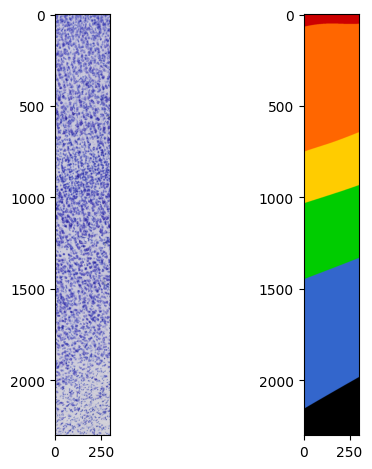

In [3]:
figs, axes = plt.subplots(1, 2)

r_range = (3000, 5300)
c_range = (6900, 7200)
axes[0].imshow(img[r_range[0]:r_range[1], c_range[0]:c_range[1]])
axes[1].imshow(img_layers[r_range[0]:r_range[1], c_range[0]:c_range[1]])

figs.tight_layout()

In [58]:
def seg_2dmrk(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im, cutoff=0.3)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    tdmrk = TwoDimMultiRegionKriging(img_full=im, # Path to image
                                    n_clusters=4, # Number of clusters
                                    max_iter_uncertain=10, # Max num of iterations to find uncertain region(s)
                                    zeta0=1.96, # Uncertainty factor
                                    p_uncertain=0.12, # Desired uncertainty region probability
                                    vario_distance=30, # Max distance on semivariogram
                                    krig_win_radius=3) # Kriging window radius

    st = time.time()
    tdmrk.train()
    print(f'Completed training in {time.time()-st:.2f} seconds.')

    st = time.time()
    out = tdmrk.infer(0)
    print(f'Completed slice {0} in {time.time()-st:.2f} seconds.')

    out = 255 - out
    out = out > 0
    out = split_touching_objects(out)

    return out

def seg_dk(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    dk = DeepKriging(img_full=im, # Image data
                    n_clusters=4, # Number of clusters
                    max_iter_uncertain=10, # Max num of iterations to find uncertain region(s)
                    zeta0=1.96, # Uncertainty factor
                    p_uncertain=0.12, # Desired uncertainty region probability
                    n_epochs=20, # Number of epochs for training neural network
                    batch_size=32) # Batch size for training data
    
    st = time.time()
    dk.train()
    print(f'Completed training in {time.time()-st:.2f} seconds.')

    st = time.time()
    out = dk.infer(0)
    print(f'Completed slice {0} in {time.time()-st:.2f} seconds.')

    out = 255 - out
    out = out > 0
    out = split_touching_objects(out)

    return out

def seg_dl(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im, cutoff=0.3)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    us = UnsupervisedSegmentation(img_full=im, # Image data
                                  n_iterations=20, # Number of iterations/epochs for training
                                  lr=0.01, # Learning rate for training
                                  n_conv=2) # Number of convolutional layers in CNN

    us.prepare_slice(0)
    us.train()
    final_segmentation = us.infer()

    final_segmentation = 255 - final_segmentation
    final_segmentation = final_segmentation > 64
    final_segmentation = split_touching_objects(final_segmentation)

    return final_segmentation

def seg_otsu(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im, cutoff=0.3)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    thresholds = threshold_multiotsu(im[0], classes=4)
    regions = np.digitize(im, bins=thresholds)

    regions[0] = regions[0] < 3
    regions[0] = split_touching_objects(regions[0])

    return regions[0]

otsu = seg_otsu(img[r_range[0]:r_range[1], c_range[0]:c_range[1]])
tdmrk = seg_2dmrk(img[r_range[0]:r_range[1], c_range[0]:c_range[1]])
dl = seg_dl(img[r_range[0]:r_range[1], c_range[0]:c_range[1]])
dk = seg_dk(img[r_range[0]:r_range[1], c_range[0]:c_range[1]])

[  0.   0. 199.] [  0.   0. 227.]
Completed training in 22.23 seconds.
Completed slice 0 in 15.56 seconds.


/home/ian/CS 789/.venv/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


1 / 20  | loss : 4.197259902954102
2 / 20  | loss : 4.129795551300049
3 / 20  | loss : 4.038165092468262
4 / 20  | loss : 3.9443697929382324
5 / 20  | loss : 3.842348575592041
6 / 20  | loss : 3.745875597000122
7 / 20  | loss : 3.654449462890625
8 / 20  | loss : 3.568236827850342
9 / 20  | loss : 3.485093355178833
10 / 20  | loss : 3.403012275695801
11 / 20  | loss : 3.3269472122192383
12 / 20  | loss : 3.2541394233703613
13 / 20  | loss : 3.1855432987213135
14 / 20  | loss : 3.118650436401367
15 / 20  | loss : 3.0535647869110107
16 / 20  | loss : 2.991407871246338
17 / 20  | loss : 2.932274341583252
18 / 20  | loss : 2.874699115753174
19 / 20  | loss : 2.8168838024139404
20 / 20  | loss : 2.7584638595581055
[  0. 148.   0.] [  0. 170.   0.]


100%|██████████| 20/20 [11:54<00:00, 35.71s/it]


Completed training in 945.95 seconds.
Completed slice 0 in 1.07 seconds.


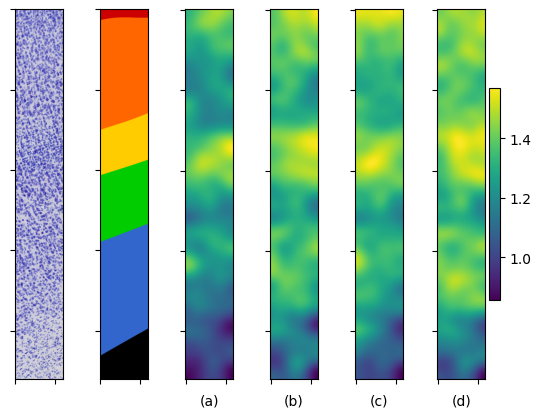

In [78]:
h = otsu.shape[0]
w = otsu.shape[1]

diff = 10

otsu_counts = np.empty(((r_range[1]-r_range[0])//diff, (c_range[1]-c_range[0])//diff))
tdmrk_counts = np.empty(((r_range[1]-r_range[0])//diff, (c_range[1]-c_range[0])//diff))
dl_counts = np.empty(((r_range[1]-r_range[0])//diff, (c_range[1]-c_range[0])//diff))
dk_counts = np.empty(((r_range[1]-r_range[0])//diff, (c_range[1]-c_range[0])//diff))

for r in range(0, h, diff):
    for c in range(0, w, diff):
        touching_labels = touching_objects_labeling(otsu[r:r+diff, c:c+diff])
        otsu_counts[r//diff, c//diff] = len(np.unique(touching_labels)) - 1

        touching_labels = touching_objects_labeling(tdmrk[r:r+diff, c:c+diff])
        tdmrk_counts[r//diff, c//diff] = len(np.unique(touching_labels)) - 1

        touching_labels = touching_objects_labeling(dl[r:r+diff, c:c+diff])
        dl_counts[r//diff, c//diff] = len(np.unique(touching_labels)) - 1

        touching_labels = touching_objects_labeling(dk[r:r+diff, c:c+diff])
        dk_counts[r//diff, c//diff] = len(np.unique(touching_labels)) - 1

figs, axes = plt.subplots(1, 6)

r_range = (3000, 5300)
c_range = (6900, 7200)
axes[0].imshow(img[r_range[0]:r_range[1], c_range[0]:c_range[1]])
axes[1].imshow(img_layers[r_range[0]:r_range[1], c_range[0]:c_range[1]])
axes[2].set_xlabel("(a)")
axes[2].imshow(gaussian_filter(otsu_counts, sigma=5))
axes[3].set_xlabel("(b)")
axes[3].imshow(gaussian_filter(tdmrk_counts, sigma=5))
axes[4].set_xlabel("(c)")
axes[4].imshow(gaussian_filter(dl_counts, sigma=5))
axes[5].set_xlabel("(d)")
ax = axes[5].imshow(gaussian_filter(dk_counts, sigma=5))
figs.colorbar(ax)

for i in range(6):
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])